### notMNISTデータの読み込み

http://yaroslavvb.com/upload/notMNIST/

上記URLより、

* notMNIST_small.tar.gz
* notMNIST_large.tar.gz

をダウンロードしてから解凍し、このJupyter notebookファイルと同じディレクトリに
配置してください。


In [1]:
from __future__ import division
import sys, os, pickle

import numpy as np
import numpy.random as rd

from scipy.misc import imread

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_size = 28
depth = 255

def unpickle(filename):
    with open(filename, 'rb') as fo:
        _dict = pickle.load(fo)
    return _dict

def to_pickle(filename, obj):
    with open(filename, 'wb') as f:
        #pickle.dump(obj, f, -1)
        pickle.Pickler(f, protocol=2).dump(obj)

def count_empty_file(folder):
    cnt = 0
    for file in os.listdir(folder):
        if os.stat(os.path.join(folder, file)).st_size == 0:
            cnt += 1
    return cnt

def draw_digit(digits):
    size = 28
    plt.figure(figsize=(len(digits)*1.5, 2))
    for i, data in enumerate(digits):
        plt.subplot(1, len(digits), i+1)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[0].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]             # flip vertical
        plt.xlim(0,27)
        plt.ylim(0,27)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.title(num2alpha[data[1]])
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")

    plt.show()
    

In [7]:
label_conv = {a: i for a, i in zip('ABCDEFGHIJ', range(10))}
num2alpha = {i: a for i,a in zip(range(10), 'ABCDEFGHIJ')}

In [5]:
assert os.path.exists('notMNIST_large')
assert os.path.exists('notMNIST_small')

In [3]:
for root_dir in ['notMNIST_small', 'notMNIST_large']:
    folders = [os.path.join(root_dir, d) for d in sorted(os.listdir(root_dir)) 
               if os.path.isdir(os.path.join(root_dir, d))]
    # 枠を作る
    file_cnt = 0
    for folder in folders:

        label_name = os.path.basename(folder)
        file_list = os.listdir(folder)
        file_cnt += len(file_list)-count_empty_file(folder)

    dataset = np.ndarray(shape=(file_cnt, image_size*image_size), dtype=np.float32)
    labels  = np.ndarray(shape=(file_cnt), dtype=np.int)
     
    last_num = 0  # 前の文字の最終インデックス

    for folder in folders:

        file_list = os.listdir(folder)
        file_cnt = len(file_list)-count_empty_file(folder)

        label_name = os.path.basename(folder)
        labels[last_num:(last_num+file_cnt)] = label_conv[label_name]

        skip = 0
        for i, file in enumerate(file_list):

            # ファイルサイズが0のものはスキップ
            if os.stat(os.path.join(folder, file)).st_size == 0:
                skip += 1
                continue
            try:
                data = imread(os.path.join(folder, file))
                data   = data.astype(np.float32)
                data  /= depth     # 0-1のデータに変換
                dataset[last_num+i-skip, :] = data.flatten()
            except:
                skip += 1
                print 'error {}'.format(file)
                continue
        last_num += i-skip
        
    notmnist = {}
    notmnist['data'] = dataset
    notmnist['target'] = labels
    to_pickle('{}.pkl'.format(root_dir), notmnist)

error RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png


### 使うとき
pklからpickleファイルをロードして、必要に応じて型の変換や<br>
訓練データ、検証データの分割などを行ってご利用ください。

In [54]:
from sklearn.cross_validation import train_test_split

notmnist = unpickle('notMNIST_large.pkl')   # 同じフォルダにnotMNIST_large.pkl が入っているとする。
notmnist_data = notmnist['data']
notmnist_target = notmnist['target']


notmnist_data   = notmnist_data.astype(np.float32)
notmnist_target   = notmnist_target.astype(np.int32)
notmnist_data  /= 255     # 0-1のデータに変換

# 学習用データを 75%、検証用データを残りの個数と設定
x_train, x_test = train_test_split(notmnist_data)
y_train, y_test =train_test_split(notmnist_target)

### 試しに表示してみる

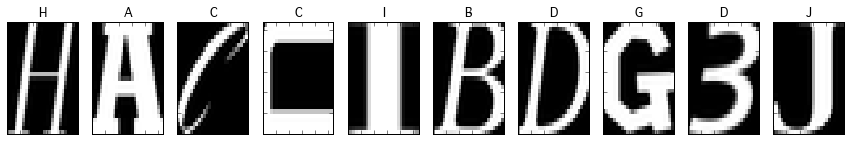

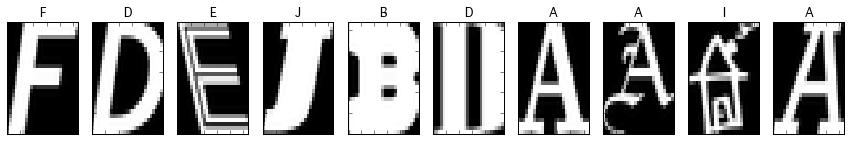

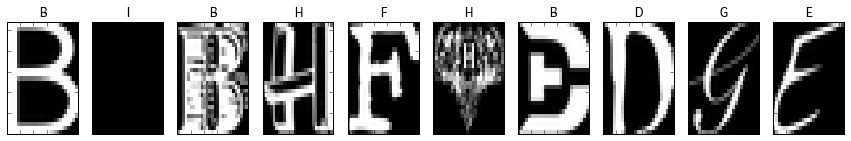

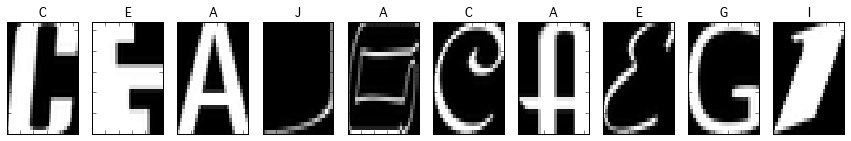

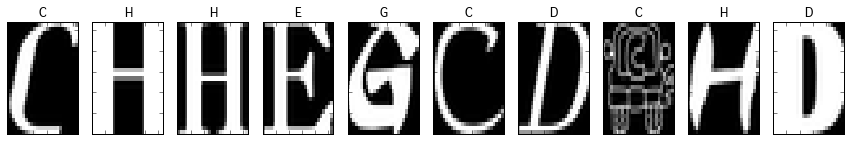

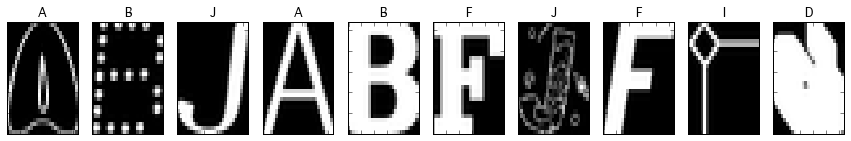

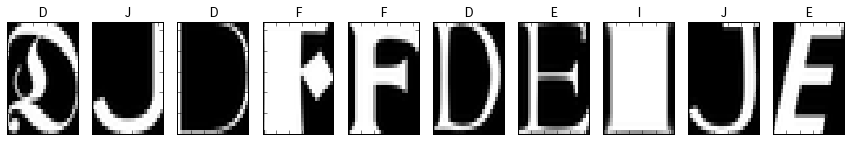

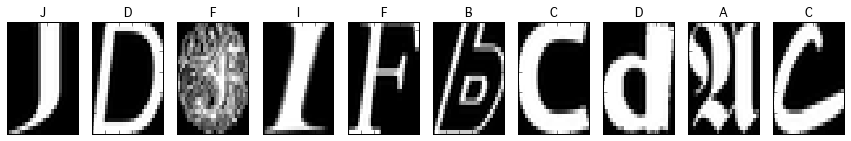

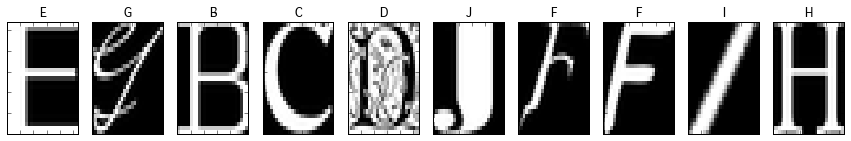

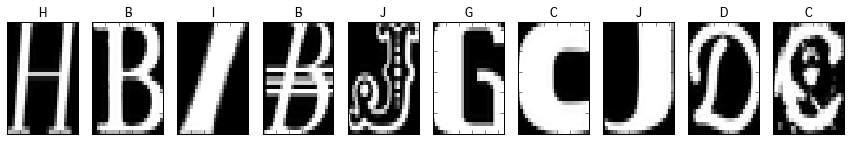

[None, None, None, None, None, None, None, None, None, None]

In [56]:
[draw_digit([[notmnist_data[idx], notmnist_target[idx]] for idx in rd.randint(len(dataset), size=10)]) for i in range(10)]

## RandomForestしてみる

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(x_train, y_train)

In [59]:
# 再代入誤り率
pred = clf.predict(x_train)
result = [y==p for y, p in zip(y_train,pred)]
np.sum(result)/len(pred)

0.90844328639538752

In [60]:
# 汎化性能チェック
pred = clf.predict(x_test)
result = [y==p for y, p in zip(y_test,pred)]
np.sum(result)/len(pred)

0.099796641946189493